In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
sns.set()

In [129]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import TensorBoard

In [151]:
# Read the data
train = pd.read_csv('train-data.csv')
# Print the first 5 rows of the dataframe
train.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [152]:
# Drop the column 'Unnamed: 0'
data = train.drop('Unnamed: 0', axis=1)
# Select only the brand of the car and not the model
data['Name'] = data['Name'].apply(lambda x: x.split(' ')[0].upper())
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price
0,MARUTI,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,1.75
1,HYUNDAI,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,12.50
2,HONDA,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,4.50
3,MARUTI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,6.00
4,AUDI,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,17.74


In [153]:
# Change the Year column to the years of usage
data['Year'] = dt.date.today().year - data['Year']

In [154]:
# Select the first word of the Mileage column
data['Mileage'] =data['Mileage'].apply(lambda x: str(x).split(' ')[0])
# Change 'nan' string to real missing values
data['Mileage'] = [x if x != 'nan' else np.nan for x in data['Mileage']]
# Convert the datatype to floating numbers
data['Mileage'] = pd.to_numeric(data['Mileage'])


# Select the first word of the Power column
data['Power'] =data['Power'].apply(lambda x: str(x).split(' ')[0])
# Change 'null' string to real missing values
data['Power'] = [np.nan if x=='null' else x for x in data['Power']]
data['Power'] = [np.nan if x=='nan' else x for x in data['Power']]
# Convert the datatype to floating numbers
data['Power'] = pd.to_numeric(data['Power'])


print(data['Mileage'].dtype, data['Power'].dtype)

float64 float64


In [155]:
# Check for null values
data.isnull().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
dtype: int64

In [156]:
# Replace missing values with median value of the column
mileage_median = data['Mileage'].median()
data['Mileage'] = data['Mileage'].fillna(mileage_median)

power_median = data['Power'].median() 
data['Power'] = data['Power'].fillna(power_median)

seat_median = data['Seats'].median()
data['Seats'] = data['Seats'].fillna(seat_median)

# Drop the remaining rows with missing value
data.dropna(axis=0, inplace=True)
# Check for missing values
data.isnull().sum().any()

False

In [157]:
# Classify the non-numerical features
cat_features = [x for x in data.columns if data[x].dtype == 'O']

# Classify the numerical features
num_features = [x for x in data.columns if data[x].dtype != 'O']

# Classify the discrete features
discrete_features = [x for x in num_features
                     if len(data[x].unique()) < 25]

# Classify the continuous features
continuous_features = [x for x in num_features
                      if x not in discrete_features]
# Check them out
print(f"Categorical features: {cat_features}\nNumerical features: {num_features}\
\nDiscrete features: {discrete_features}\nContinuous features: {continuous_features}")

Categorical features: ['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Engine']
Numerical features: ['Year', 'Kilometers_Driven', 'Mileage', 'Power', 'Seats', 'Price']
Discrete features: ['Year', 'Seats']
Continuous features: ['Kilometers_Driven', 'Mileage', 'Power', 'Price']


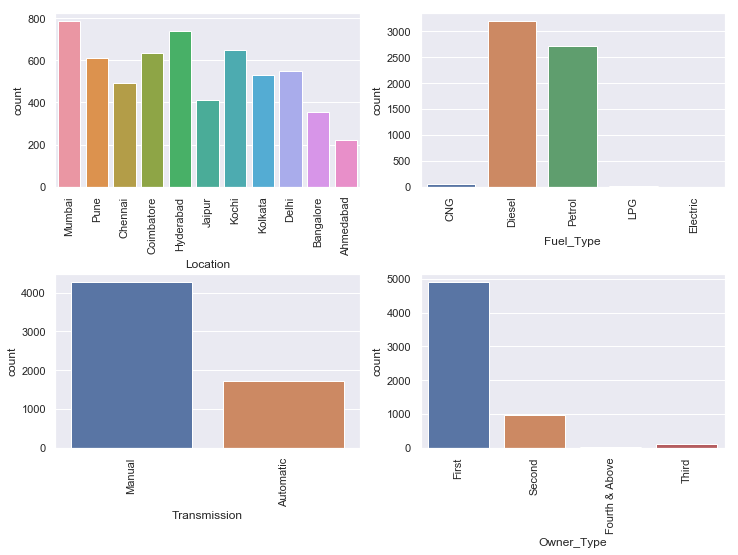

In [158]:
# Create a figure with 4 subplots
fig, ax = plt.subplots(2,2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

# Plot the number of times it entry appears
a = sns.countplot(cat_features[1], data=data, ax=ax[0][0])
a.set_xticklabels(a.get_xticklabels(), rotation='vertical')
b = sns.countplot(cat_features[2], data=data, ax=ax[0][1])
b.set_xticklabels(b.get_xticklabels(), rotation='vertical')
c = sns.countplot(cat_features[3], data=data, ax=ax[1][0])
c.set_xticklabels(c.get_xticklabels(), rotation='vertical')
d = sns.countplot(cat_features[4], data=data, ax=ax[1][1])
d.set_xticklabels(d.get_xticklabels(), rotation='vertical')



plt.show()


''

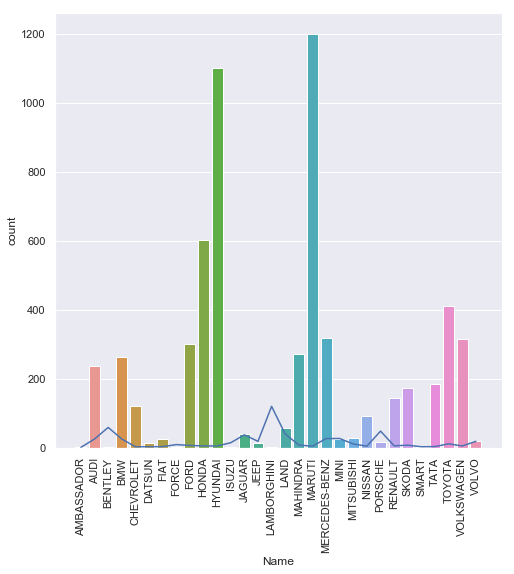

In [159]:
# Create a figure
plt.figure(figsize=(8, 8))
# Count the number of times a car was bought and plot the graph
count = sns.countplot(cat_features[0], data=data, order=data.groupby('Name').mean()['Price'].index)
count.set_xticklabels(count.get_xticklabels(), rotation='vertical')

# Plot the mean price of each car
price = sns.lineplot(data.groupby('Name').mean()['Price'].index, data.groupby('Name').mean()['Price'].values)
;

''

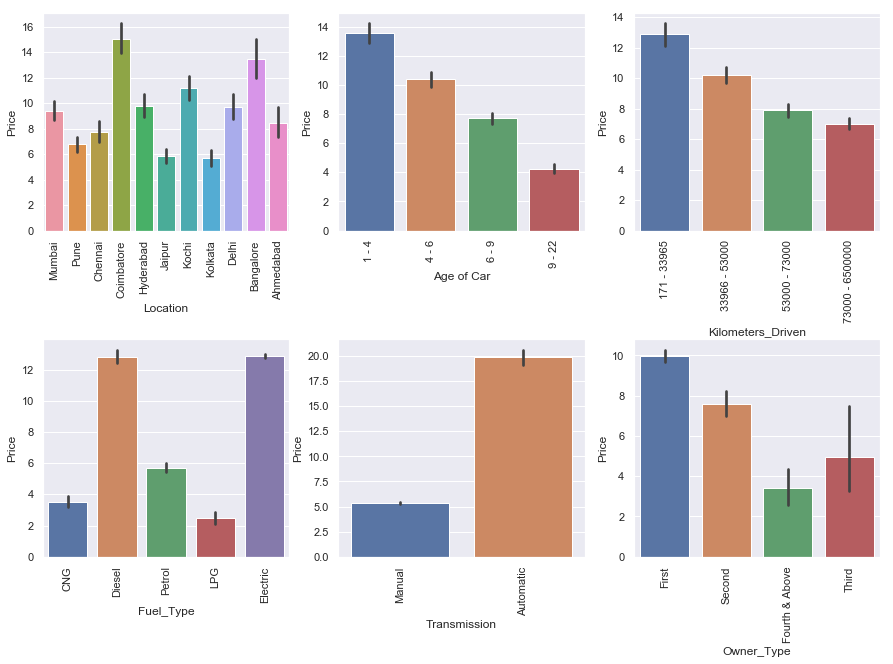

In [160]:
# Create a figure with 6 subplots
fig, ax = plt.subplots(2,3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

# Graph each categorical feature wrt to thee Price
a = sns.barplot(data.columns[1], 'Price', data=data, ax=ax[0][0])
a.set_xticklabels(a.get_xticklabels(), rotation='vertical')

b = sns.barplot(pd.qcut(data[data.columns[2]], 4), 'Price', data=data, ax=ax[0][1])
b.set_xticklabels(['1 - 4', '4 - 6', '6 - 9', '9 - 22'], rotation='vertical')
b.set_xlabel('Age of Car')

c = sns.barplot(pd.qcut(data[data.columns[3]], 4), 'Price', data=data, ax=ax[0][2])
c.set_xticklabels(['171 - 33965', '33966 - 53000', '53000 - 73000', '73000 - 6500000'], rotation='vertical')

d = sns.barplot(data.columns[4], 'Price', data=data, ax=ax[1][0])
d.set_xticklabels(d.get_xticklabels(), rotation='vertical')

e = sns.barplot(data.columns[5], 'Price', data=data, ax=ax[1][1])
e.set_xticklabels(e.get_xticklabels(), rotation='vertical')

f = sns.barplot(data.columns[6], 'Price', data=data, ax=ax[1][2])
f.set_xticklabels(f.get_xticklabels(), rotation='vertical')

;

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


''

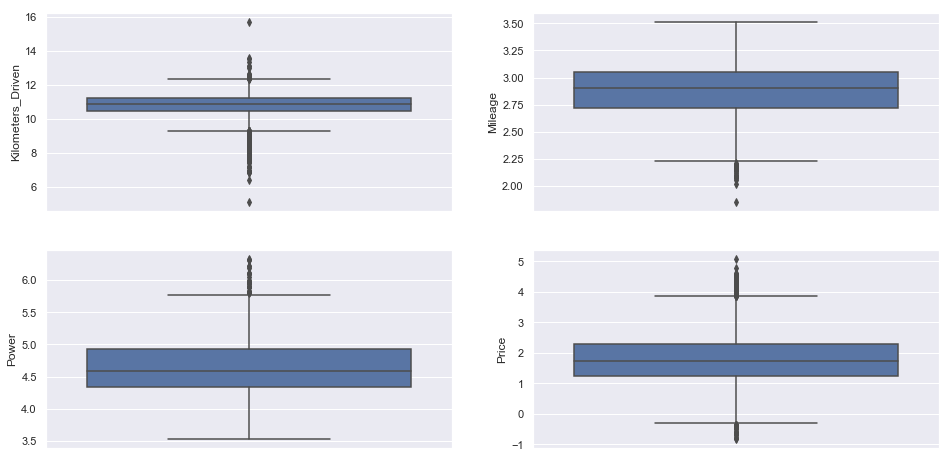

In [161]:
data1 = data.copy()

# Create a figure with 4 subplots    
fig, ax = plt.subplots(2,2, figsize=(16,8))

# Create a boxplot for the continuous features
box1 = sns.boxplot(y=np.log(data1[continuous_features[0]]), ax=ax[0][0])
box2 = sns.boxplot(y=np.log(data1[continuous_features[1]]), ax=ax[0][1])
box3 = sns.boxplot(y=np.log(data1[continuous_features[2]]), ax=ax[1][0])
box4 = sns.boxplot(y=np.log(data1[continuous_features[3]]), ax=ax[1][1])
;


In [162]:
data = data.drop(['Location', 'Engine'], axis=1)
cat_features = [x for x in data.columns if data[x].dtype == 'O']
data = pd.get_dummies(data, cat_features)

In [163]:
# cat_features = ['Name', 'Fuel_Type', 'Transmission', 'Owner_Type']

In [164]:
# Define the features or independent variable
X = data.drop(['Price'], axis=1)
# Define the label or dependent variable
y = data['Price']

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Robust Scaler to the train data
scaler = StandardScaler()
scaler.fit(X_train[continuous_features[0:-1]])

# Transform Robust Scaler to the train and test data
X_train[continuous_features[0:-1]] = scaler.transform(X_train[continuous_features[0:-1]])
X_test[continuous_features[0:-1]] = scaler.transform(X_test[continuous_features[0:-1]])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

In [165]:
X_train.shape, y_train.shape

((4786, 46), (4786,))

In [166]:
# def baseline_model():
#     model = Sequential()
#     model.add(Dense(60, input_dim=46, kernel_initializer='he_uniform', activation='relu'))
#     model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
#     model.add(Dropout(0.3))
#     model.add(Dense(20, kernel_initializer='normal', activation='relu'))
#     model.add(Dropout(0.1))
#     model.add(Dense(1))
    
#     model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#     return model

              
# #evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100)
# fold = KFold(n_splits=10)
# score = cross_val_score(estimator, X_train, y_train, cv=fold)

# print(f"The basline model score is {score.mean()} with a standard devaition of {score.std()}")

In [167]:
tensorboard = TensorBoard()
model = Sequential()
model.add(Dense(60, input_dim=46, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(40, kernel_initializer='he_uniform', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])


In [168]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[tensorboard])

Train on 4786 samples, validate on 1197 samples
Epoch 1/100
4786/4786 [==============================] - 4s 909us/sample - loss: 120.6852 - mean_squared_error: 120.6852 - val_loss: 38.2924 - val_mean_squared_error: 38.2924
Epoch 2/100
4786/4786 [==============================] - 1s 248us/sample - loss: 34.5819 - mean_squared_error: 34.5819 - val_loss: 20.9546 - val_mean_squared_error: 20.9546
Epoch 3/100
4786/4786 [==============================] - 2s 353us/sample - loss: 27.8078 - mean_squared_error: 27.8078 - val_loss: 18.7512 - val_mean_squared_error: 18.7512
Epoch 4/100
4786/4786 [==============================] - 2s 343us/sample - loss: 24.6178 - mean_squared_error: 24.6178 - val_loss: 18.8864 - val_mean_squared_error: 18.8864
Epoch 5/100
4786/4786 [==============================] - 1s 256us/sample - loss: 25.5200 - mean_squared_error: 25.5200 - val_loss: 17.7665 - val_mean_squared_error: 17.7665
Epoch 6/100
4786/4786 [==============================] - 2s 313us/sample - loss: 22.4

Epoch 48/100
4786/4786 [==============================] - 1s 209us/sample - loss: 12.8740 - mean_squared_error: 12.8740 - val_loss: 15.6145 - val_mean_squared_error: 15.6145
Epoch 49/100
4786/4786 [==============================] - 1s 208us/sample - loss: 15.4154 - mean_squared_error: 15.4154 - val_loss: 14.0758 - val_mean_squared_error: 14.0758
Epoch 50/100
4786/4786 [==============================] - 1s 216us/sample - loss: 15.5816 - mean_squared_error: 15.5816 - val_loss: 14.3932 - val_mean_squared_error: 14.3932
Epoch 51/100
4786/4786 [==============================] - 1s 218us/sample - loss: 14.0923 - mean_squared_error: 14.0923 - val_loss: 13.9090 - val_mean_squared_error: 13.9090
Epoch 52/100
4786/4786 [==============================] - 1s 230us/sample - loss: 13.2430 - mean_squared_error: 13.2430 - val_loss: 14.1305 - val_mean_squared_error: 14.1305
Epoch 53/100
4786/4786 [==============================] - 1s 213us/sample - loss: 12.5779 - mean_squared_error: 12.5779 - val_loss

4786/4786 [==============================] - 1s 222us/sample - loss: 10.2569 - mean_squared_error: 10.2569 - val_loss: 13.3040 - val_mean_squared_error: 13.3040
Epoch 96/100
4786/4786 [==============================] - 1s 218us/sample - loss: 11.8535 - mean_squared_error: 11.8535 - val_loss: 13.1762 - val_mean_squared_error: 13.1762
Epoch 97/100
4786/4786 [==============================] - 1s 218us/sample - loss: 11.0196 - mean_squared_error: 11.0196 - val_loss: 14.0529 - val_mean_squared_error: 14.0529
Epoch 98/100
4786/4786 [==============================] - 1s 221us/sample - loss: 11.0366 - mean_squared_error: 11.0366 - val_loss: 13.5999 - val_mean_squared_error: 13.5999
Epoch 99/100
4786/4786 [==============================] - 1s 222us/sample - loss: 10.7469 - mean_squared_error: 10.7469 - val_loss: 13.4319 - val_mean_squared_error: 13.4319
Epoch 100/100
4786/4786 [==============================] - 1s 219us/sample - loss: 11.0986 - mean_squared_error: 11.0986 - val_loss: 13.9124 - 

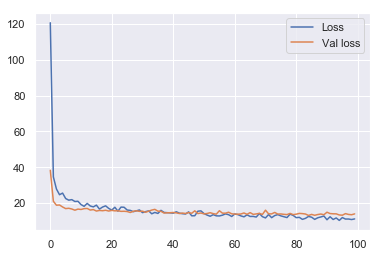

In [169]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Define some paramters
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



In [31]:
# Apply GridSearchCV with the defined paramters
model_search = RandomizedSearchCV(rf, param_distributions=params, scoring='r2')
%time model_search.fit(X_train, y_train)
y_pred_op = model_search.predict(X_test)

# Check metrics
print(f'r2 score: {r2_score(y_test, y_pred_op)}')

CPU times: user 13min 24s, sys: 1.41 s, total: 13min 25s
Wall time: 13min 26s
r2 score: 0.8739563541355833


In [32]:
model_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 2000}

In [33]:
model_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [34]:
# Define a function that implements the model
def predict_price(name, year, km, fuel, transmission, owner, mileage, power, seats):
#     Define column location of the non numerical features
    name_index = np.where(X.columns=='Name_'+name.upper())[0][0]
    fuel_index = np.where(X.columns=='Fuel_Type_'+fuel)[0][0]
    transmission_index = np.where(X.columns=='Transmission_'+transmission)[0][0]
    owner_index = np.where(X.columns=='Owner_Type_'+owner)[0][0]
#     Assign each of the inputted feature its value
    x = np.zeros(len(X.columns))
    x[0] = year
    x[1] = km
    x[2] = mileage
    x[3] = power
    x[4] = seats
    if name_index >= 0:
        x[name_index] = 1
    if fuel_index >= 0:
        x[fuel_index] = 1
    if transmission_index >= 0:
        x[transmission_index] = 1
    if owner_index >= 0:
        x[owner_index] = 1
    
    return f'The estimated price of the car is {model_search.predict([x])[0]} Lakh Rupees'

In [35]:
predict_price('maruti', 10, 100000, 'Petrol', 'Manual', 'First', 30, 50, 7)


'The estimated price of the car is 31.097694071789316 Lakh Rupees'

In [36]:
predict_price('toyota', 5, 30000, 'Petrol', 'Automatic', 'Second', 25, 150, 4)

'The estimated price of the car is 68.4407928003246 Lakh Rupees'

In [37]:
predict_price('land', 3, 30000, 'Petrol', 'Automatic', 'First', 20, 250, 4)

'The estimated price of the car is 81.73010602326852 Lakh Rupees'

In [38]:
predict_price('honda', 10, 70000, 'Petrol', 'Manual', 'First', 50, 50, 7)

'The estimated price of the car is 31.097694071789316 Lakh Rupees'

In [39]:
# Save the model
pickle.dump(model_search, open('model_final.plk', 'wb'))